# Entrenamiento - datos y limpieza

Ahora que ya tenemos todo el código necesario para un transformer vamos a entrenar uno, pero primero tenemos que descargarnos un dataset y hacerle una pequeña limpieza

## Datos

Como hemos dicho en el notebook anterior vamos a usar el dataset [opus100](https://huggingface.co/datasets/opus100) del inglés al español (`en-es`)

In [1]:
from datasets import load_dataset

opus100 = load_dataset("opus100", "en-es")

Vamos a analizar un poco el dataset, primero veamos el tipo de dato

In [2]:
print(f"dataset type: {type(opus100)}")

dataset type: <class 'datasets.dataset_dict.DatasetDict'>


Veamos ahora qué llaves tiene

In [3]:
print(f"dataset keys: {opus100.keys()}")

dataset keys: dict_keys(['test', 'train', 'validation'])


Veamos la longitud de cada uno

In [4]:
print(f"train length: {len(opus100['train'])},\nvalidation length: {len(opus100['validation'])},\ntest length: {len(opus100['test'])}")

train length: 1000000,
validation length: 2000,
test length: 2000


Veamos cómo son por dentro

In [5]:
print(f"train keys: {opus100['train'][0].keys()},\nvalidation keys: {opus100['validation'][0].keys()},\ntest keys: {opus100['test'][0].keys()}")

train keys: dict_keys(['translation']),
validation keys: dict_keys(['translation']),
test keys: dict_keys(['translation'])


Vemos que todos tienen una `key` llamada `translation`, veamos qué más tienen por dentro

In [6]:
print(f"train translation keys: {opus100['train'][0]['translation'].keys()},\nvalidation translation keys: {opus100['validation'][0]['translation'].keys()},\ntest translation keys: {opus100['test'][0]['translation'].keys()}")

train translation keys: dict_keys(['en', 'es']),
validation translation keys: dict_keys(['en', 'es']),
test translation keys: dict_keys(['en', 'es'])


Terminemos ya con un ejemplo

In [8]:
import numpy.random as random
idx = random.randint(0, len(opus100["train"]))
opus100["train"][idx]["translation"]

{'en': "He hasn't got any luck, the poor guy.",
 'es': '¡No tiene suerte aquel pobre chico!'}

## Limpieza

Siempre en un problema de lenguaje hay que hacer una limpieza de los datos, porque podemos encontrarnos frases malas que no van a aportar, sino que solo van a empeorar el modelo

Antes de hacer la limpieza veamos otra vez las longitudes de los datasets

In [9]:
print(f"len dataset train: {len(opus100['train'])}")
print(f"len dataset validation: {len(opus100['validation'])}")
print(f"len dataset test: {len(opus100['test'])}")

len dataset train: 1000000
len dataset validation: 2000
len dataset test: 2000


Vamos a hacer una limpieza muy sencilla, vamos a crear una lista de caracteres `extraños` que no suelen estar en una frase del inglés o del español y vamos a eliminar esas frases. Para buscar esos caracteres nos vamos a una [tabla ASCII](https://www.rapidtables.com/code/text/ascii-table.html) y buscamos caracteres que creamos que no suelen estar en una frase del inglés o del español.

En mi caso son estos

In [10]:
ilegal_chars = ['¢', '¤', '¥', '¦', '§', '¨', '©', '¬', '¯', '¶', '¸', 'À', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'È', 'Ê', 'Ë', 'Ì', 'Î', 'Ï', 'Ð', 'Ò', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Û', 'Ý', 'Þ', 'ß', 'à', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'ê', 'ë', 'ì', 'î', 'ï', 'ð', 'ò', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'û', 'ü', 'ý', 'þ', 'ÿ']

Vamos a eliminar del dataset las frases que contengan estos caracteres `extraños`

In [11]:
opus100_cleaned = opus100.filter(lambda example: all([char not in example["translation"]["en"] for char in ilegal_chars]) and all([char not in example["translation"]["es"] for char in ilegal_chars]))

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
print(f"len dataset train: {len(opus100_cleaned['train'])}, se han eliminado {len(opus100['train']) - len(opus100_cleaned['train'])} ejemplos")
print(f"len dataset validation: {len(opus100_cleaned['validation'])}, se han eliminado {len(opus100['validation']) - len(opus100_cleaned['validation'])} ejemplos")
print(f"len dataset test: {len(opus100_cleaned['test'])}, se han eliminado {len(opus100['test']) - len(opus100_cleaned['test'])} ejemplos")
print(f"En total se han eliminado {len(opus100['train']) + len(opus100['validation']) + len(opus100['test']) - len(opus100_cleaned['train']) - len(opus100_cleaned['validation']) - len(opus100_cleaned['test'])} ejemplos")

len dataset train: 993255, se han eliminado 6745 ejemplos
len dataset validation: 1987, se han eliminado 13 ejemplos
len dataset test: 1976, se han eliminado 24 ejemplos
En total se han eliminado 6782 ejemplos


Se han eliminado 6782 ejemplos, pero seguimos teniendo muchos ejemplos aun así. Posíblemente hayamos eliminado ejemplos que serían válidos, pero igualmente seguimos teniendo muchos, pero aunque hayamos perdido algún ejemplo que pueda ser válido, hemos borrado muchos ejemplos que seguro son malos. Es un pequeño peaje que tenemos que pagar por hacer una limpieza rápida para no mirar los ejemplos uno a uno

## Tokenización

Ya tenemos un dataset con frases en inglés y español, pero hemos visto que no podemos meter las frases como tal al transformer. Porque como hemos visto, el transformer consiste en un montón de operaciones matriciales, por lo que tenemos que meterle números, no frases. Y a este proceso ya vimos, se le llama  tokenización.

Antes vimos el tokenizador de BERT, pero ahora, por dar uno nuevo y porque posiblemente sea mejor, vamos a usar el tokenizazor de GPT, [tiktoken](https://github.com/openai/tiktoken)

In [13]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")

encode = enc.encode("Voy a entrenar un traductor")
decode = enc.decode(encode)
print(f"encode: {encode}, decode: {decode}")

encode: [53, 2303, 264, 94921, 277, 653, 4790, 80322], decode: Voy a entrenar un traductor


Como vemos a creado tokens a partir de una frase y ha creado una frase a partir de tokens

### Start y end tokens

Hemos visto que necesitamos definir un `start token` y un `end token`. Si volvemos a la [tabla ASCII](https://www.rapidtables.com/code/text/ascii-table.html), podemos ver que los primeros caracteres (1 y 2) no son caracteres como tal, sino que son caracteres de control. Así que los vamos a utilizar como tokens de start y end ya que seguramente no estén en ninguna frase

Aun así buscamos a ver si están en alguna frase, esta celda va a tardar bastante

In [14]:
start_token = chr(1)
encode = enc.encode(start_token)
decode = enc.decode(encode)
print(f"start_token encode: {encode}, decode: {decode}")
end_token = chr(2)
encode = enc.encode(end_token)
decode = enc.decode(encode)
print(f"end_token encode: {encode}, decode: {decode}")

start_token encode: [189], decode: 
end_token encode: [190], decode: 


In [15]:
subset = "train"
for i in range(len(opus100_cleaned[subset])):
    if start_token in opus100_cleaned[subset][i]["translation"]["en"]:
        print(f"start token in {i} index of {subset} en: {opus100_cleaned[subset][i]['translation']['en']}, es: {opus100[subset][i]['translation']['es']}")
        break
    if start_token in opus100_cleaned[subset][i]["translation"]["es"]:
        print(f"start token in {i} index of {subset} es: {opus100_cleaned[subset][i]['translation']['es']}, en: {opus100[subset][i]['translation']['en']}")
        break
    if end_token in opus100_cleaned[subset][i]["translation"]["en"]:
        print(f"end token in {i} index of {subset} en: {opus100_cleaned[subset][i]['translation']['en']}, es: {opus100[subset][i]['translation']['es']}")
        break
    if end_token in opus100_cleaned[subset][i]["translation"]["es"]:
        print(f"end token in {i} index of {subset} es: {opus100_cleaned[subset][i]['translation']['es']}, en: {opus100[subset][i]['translation']['en']}")
        break

subset = "validation"
for i in range(len(opus100_cleaned[subset])):
    if start_token in opus100_cleaned[subset][i]["translation"]["en"]:
        print(f"start token in {i} index of {subset} en: {opus100_cleaned[subset][i]['translation']['en']}, es: {opus100[subset][i]['translation']['es']}")
        break
    if start_token in opus100_cleaned[subset][i]["translation"]["es"]:
        print(f"start token in {i} index of {subset} es: {opus100_cleaned[subset][i]['translation']['es']}, en: {opus100[subset][i]['translation']['en']}")
        break
    if end_token in opus100_cleaned[subset][i]["translation"]["en"]:
        print(f"end token in {i} index of {subset} en: {opus100[subset][i]['translation']['en']}, es: {opus100[subset][i]['translation']['es']}")
        break
    if end_token in opus100_cleaned[subset][i]["translation"]["es"]:
        print(f"end token in {i} index of {subset} es: {opus100_cleaned[subset][i]['translation']['es']}, en: {opus100[subset][i]['translation']['en']}")
        break

subset = "test"
for i in range(len(opus100_cleaned[subset])):
    if start_token in opus100_cleaned[subset][i]["translation"]["en"]:
        print(f"start token in {i} index of {subset} en: {opus100_cleaned[subset][i]['translation']['en']}, es: {opus100[subset][i]['translation']['es']}")
        break
    if start_token in opus100_cleaned[subset][i]["translation"]["es"]:
        print(f"start token in {i} index of {subset} es: {opus100_cleaned[subset][i]['translation']['es']}, en: {opus100[subset][i]['translation']['en']}")
        break
    if end_token in opus100_cleaned[subset][i]["translation"]["en"]:
        print(f"end token in {i} index of {subset} en: {opus100_cleaned[subset][i]['translation']['en']}, es: {opus100[subset][i]['translation']['es']}")
        break
    if end_token in opus100_cleaned[subset][i]["translation"]["es"]:
        print(f"end token in {i} index of {subset} es: {opus100_cleaned[subset][i]['translation']['es']}, en: {opus100[subset][i]['translation']['en']}")
        break

No hay ninguna frase que contenga estos caracteres, así que los podemos usar como tokens de start y end

## Tamaño del vocabulario y dimensión del embedding

Una vez tenemos el tokenizador ya podemos convertir las frases en tokens. Vamos a ver otra vez cómo sería una frase tokenizada y además añadiéndole los tokens de start y end

In [16]:
sentence = "Voy a entrenar un traductor"
encode_sentence = enc.encode(sentence)

start_token = chr(1)
start_token = enc.encode(start_token)

end_token = chr(2)
end_token = enc.encode(end_token)

encode_sentence = start_token + encode_sentence + end_token
print(f"encode sentence: {encode_sentence}")

decode = enc.decode(encode_sentence[1:-1])
print(f"dencode sentence: {decode}")

encode sentence: [189, 53, 2303, 264, 94921, 277, 653, 4790, 80322, 190]
dencode sentence: Voy a entrenar un traductor


Esta secuencia entraría al input embedding, vamos a recordar cómo era la clase

``` python
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)
```

Por lo que necesitamos la dimensión del embedding (`embedding_dim`) y el tamaño del vocabulario (`vocab_size`)

Para el tamaño del embedding vamos a usar el que usaron en el paper, que es `512`

El tamaño del vocabulario es la cantidad de tokens distintos que tiene el tokenizador, así que vamos a verlo

In [17]:
vocab_size = enc.n_vocab
vocab_size

100277

Vemos que el tokenizador tiene `100277` tokens diferentes, por lo que el tamaño del vocabulario será ese

Ya podemos crear un objeto para el input embedding

In [18]:
import torch
import torch.nn as nn

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)
    
embedding_dim = 512
vocab_size = enc.n_vocab
embedding = Embedding(vocab_size, embedding_dim)

## Tamáño máximo de la secuencia

Vamos a ver cómo sería la secuencia tokenizada anterior tras pasar por el embeddin. Primero hay que convertir la secuencia a un tensor

In [21]:
torch_sentence = torch.tensor(encode_sentence)
torch_sentence, torch_sentence.shape

(tensor([  189,    53,  2303,   264, 94921,   277,   653,  4790, 80322,   190]),
 torch.Size([10]))

In [20]:
word_embedding = embedding(torch_sentence)
print(f"word embedding shape: {word_embedding.shape}")

word embedding shape: torch.Size([10, 512])


Vemos que tenemos una matriz de 10x512, lo cual es lógico, porque la frase tokenizada nos había dado 10 tokens

In [22]:
len(encode_sentence)

10

Y cada token se convierte en un vector del tamaño del embedding (512)

Pero veamos ahora el tamaño de otra frase

In [23]:
sentence = "Hola caracola"
encode_sentence = enc.encode(sentence)
encode_sentence = start_token + encode_sentence + end_token
torch_sentence = torch.tensor(encode_sentence)
word_embedding = embedding(torch_sentence)
print(f"word embedding shape: {word_embedding.shape}")

word embedding shape: torch.Size([6, 512])


Vaya, ahora la matriz es de 6x512. Vemos que se mantiene constante el 512, que es la dimensión del embedding, es decir, cada token se ha convertido en un vector de 512 valores. Pero claro, la sentencia de antes tenía 10 tokens, mientras que esta tiene 6 tokens

Hemos visto que para entrenar una red neuronal le metemos batches, en este caso le meteríamos unas cuantas frases distintas agrupadas todas en una matriz, pero la matriz no puede tener una fila con tamaño 6x512, otra de tamaño 10x512, etc. Necesitamos meterle una matriz en la que todas sus filas tengan el mismo tamaño

Lo que se hace es definir un tamaño máximo de secuencia, de manera que todo lo que sobre en la secuencia se rellenará con tokens vacíos. Por eso tiene mucho sentido el token de final de secuencia, porque así sabes que la secuencia habrá terminado y todo lo siguiente no tendrá valor

Pero ¿qué tamaño máximo de secuencia definimos? Vamos a ver los tamaños de las secuencias de nuestros datos y en función de eso decidimos

Primero obtenemos todos los tamaños de secuencia y los guardamos en variables

In [24]:
import numpy as np

sentence_lengths_train_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_cleaned["train"]])
sentence_lengths_train_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_cleaned["train"]])
sentence_lengths_validation_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_cleaned["validation"]])
sentence_lengths_validation_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_cleaned["validation"]])
sentence_lengths_test_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_cleaned["test"]])
sentence_lengths_test_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_cleaned["test"]])

Representamos su histograma

Text(0.5, 1.0, 'test es')

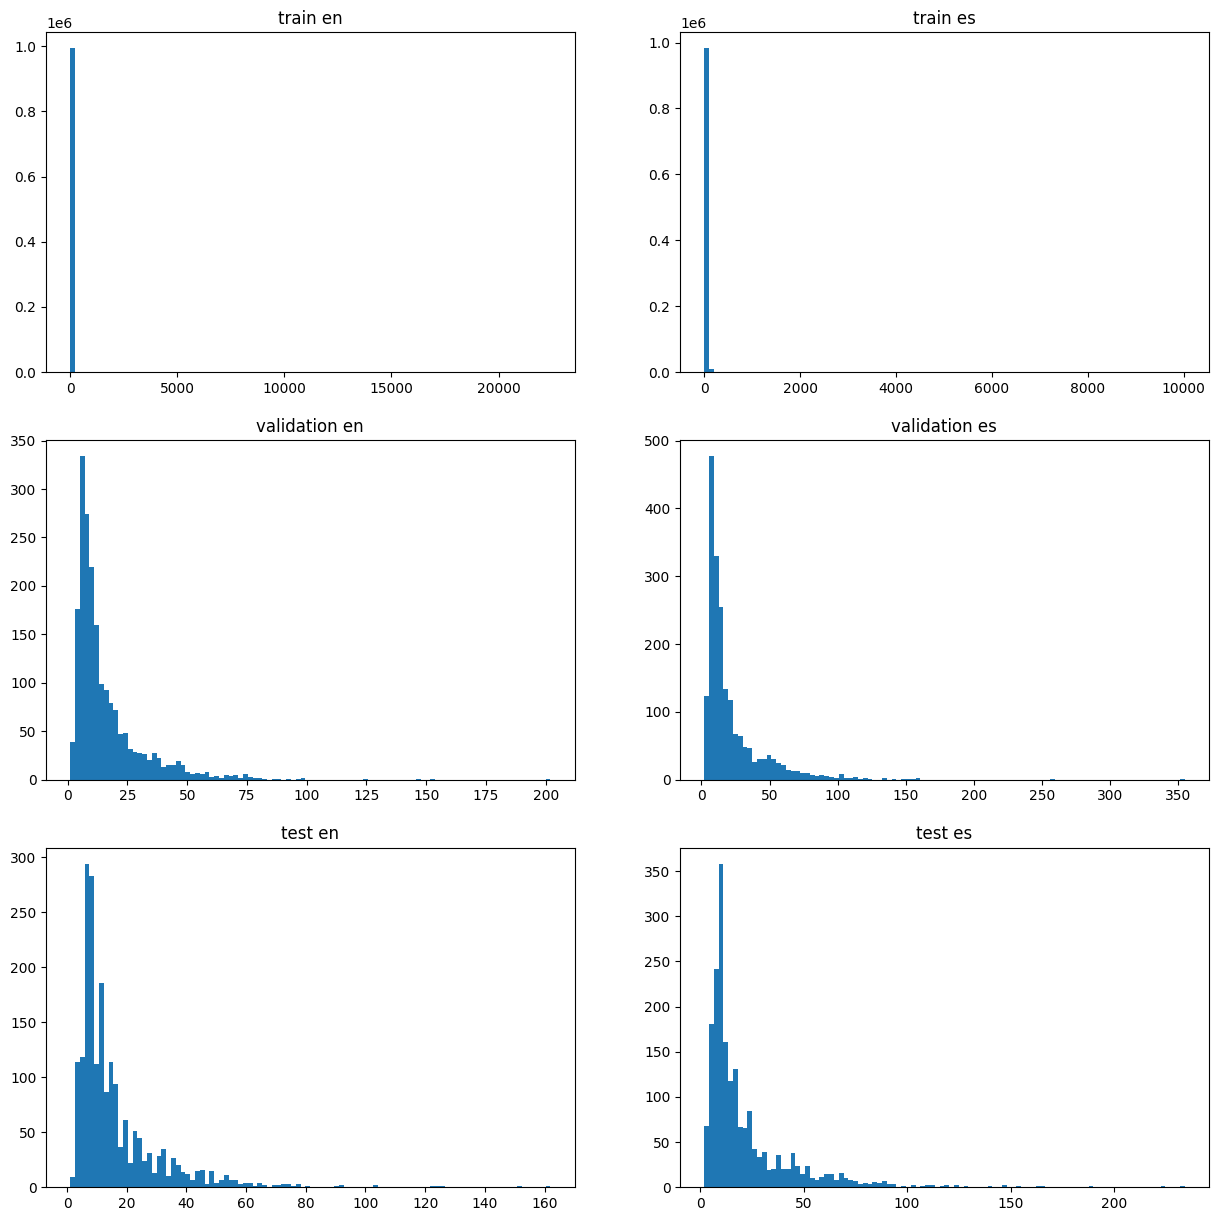

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Podemos ver que la mayoría de tamaños de las secuancias están agrupadas al inicio, es decir, no hay muchas secuencias muy largas

Vamos a ver los tamaños más grande del conjunto de entrenamiento en inglés

In [26]:
sentence_lengths_train_en_sorted = np.sort(sentence_lengths_train_en)
sentence_lengths_train_en_sorted[-10:]

array([  843,   887,   972,  1042,  1081,  1232,  1304,  1559,  1994,
       22427])

Vemos que la secuencia más grande tiene un tamaño de 22427 tokens, pero la siguiente más grande tiene 1994 tokens

Vamos a ver cómo es la secuencia más larga del conjunto de entrenamiento en inglés

In [27]:
idx = int(np.where(sentence_lengths_train_en == sentence_lengths_train_en_sorted[-1])[0])
sentence_en = opus100_cleaned["train"][idx]["translation"]["en"]
encode_sentence_en = enc.encode(sentence_en)
sentence_es = opus100_cleaned["train"][idx]["translation"]["es"]
encode_sentence_es = enc.encode(sentence_es)
print(len(encode_sentence_en), sentence_en)
print(len(encode_sentence_es), sentence_es)

22427 Fifty-ninth session * A/59/50 and Corr.1. Item 118 of the preliminary list* Joint Inspection Unit Report of the Joint Inspection Unit on the evaluation of the United Nations Volunteers Programme Note by the Secretary-General The Secretary-General has the honour to transmit to the members of the General Assembly the report of the Joint Inspection Unit entitled “Evaluation of the United Nations Volunteers Programme” (JIU/REP/2003/7). Prepared by Armando Duque González Joint Inspection Unit Geneva ALD appointment of limited duration CIS Commonwealth of Independent States CIVICUS World Alliance for Citizen Participation CMT Core Management Team DPKO Department of Peacekeeping Operations ERP Enterprise Resource Planning FAO Food and Agriculture Organization of the United Nations IAVE International Association for Voluntary Effort IBFL International Business Leader Forum ICSC International Civil Service Commission IFRC International Federation of Red Cross and Red Crescent Societies IL

Tiene pinta de ser una cita en la que solo se ha traducido lo importante

Vamos a hacer lo mismo con las secuencias de entrenamiento en español, primero vamos las más largas

In [28]:
sentence_lengths_train_es_sorted = np.sort(sentence_lengths_train_es)
sentence_lengths_train_es_sorted[-10:]

array([  974,   981,  1009,  1370,  1503,  1579,  1791,  2023,  2124,
       10020])

Al igual que antes vemos que la más larga es mucho más larga que la anterior. Vemos la secuencia más larga en español

In [29]:
idx = int(np.where(sentence_lengths_train_es == sentence_lengths_train_es_sorted[-1])[0])
sentence_en = opus100_cleaned["train"][idx]["translation"]["en"]
encode_sentence_en = enc.encode(sentence_en)
sentence_es = opus100_cleaned["train"][idx]["translation"]["es"]
encode_sentence_es = enc.encode(sentence_es)
print(len(encode_sentence_en), sentence_en)
print(len(encode_sentence_es), sentence_es)

292 Fifty-eighth session Agenda item 44 Culture of peace Letter dated 31 October 2003 from the Chargé d'affaires a.i. of the Permanent Mission of Indonesia to the United Nations addressed to the President of the General Assembly I have the honour, on behalf of the member countries of the Association of South-East Asian Nations (ASEAN), namely, Brunei Darussalam, Cambodia, Indonesia, the Lao People's Democratic Republic, Malaysia, Myanmar, the Philippines, Singapore, Thailand and Viet Nam, to forward herewith copies of: (a) The Declaration of ASEAN Concord II (Bali Concord II) (see annex I); (b) A press statement issued by the Chairperson of the Ninth ASEAN Summit and the Seventh ASEAN Plus Three Summit (see annex II). As you may be aware, those documents were issued at the Ninth ASEAN Summit, which was convened in Bali, Indonesia, on 7 and 8 October 2003. In this regard, I have the further honour to kindly request that the present letter and its annexes be circulated as a document of t

Al igual que antes, parece una cita en la que solo se ha traducido lo importante

Vamos a ver las longitudes máximas si nos quedamos con el 99% de las secuencias más cortas, es decir, casi todas

In [30]:
percentage = 0.99
sentence_lengths_train_en_sorted = np.sort(sentence_lengths_train_en)
sentence_lengths_train_en_sorted = sentence_lengths_train_en_sorted[:int(len(sentence_lengths_train_en_sorted)*percentage)]
sentence_lengths_train_en_sorted[-10:]

array([72, 72, 72, 72, 72, 72, 72, 72, 72, 72])

En el 99% del dataset de entrenamiento en inglés tiene una longitud máxima de 72 tokens

In [31]:
percentage = 0.99
sentence_lengths_train_es_sorted = np.sort(sentence_lengths_train_es)
sentence_lengths_train_es_sorted = sentence_lengths_train_es_sorted[:int(len(sentence_lengths_train_es_sorted)*percentage)]
sentence_lengths_train_es_sorted[-10:]

array([104, 104, 104, 104, 104, 104, 104, 104, 104, 104])

Mientras que el 99% del dataset de entrenamiento en español tiene una longitud máxima de 104 tokens

Así que definimos la longitud máxima de secuencia como el máximo de de estas dos longitudes

In [32]:
max_sequence_len = int(np.max([int(sentence_lengths_train_en_sorted[-1]), int(sentence_lengths_train_es_sorted[-1])]))
max_sequence_len

104

## Guardar los datos limpiados

Creamos un nuevo dataset eliminando las secuencias con más de 104 tokens

In [33]:
opus100_croped = opus100_cleaned.filter(lambda example: len(enc.encode(example["translation"]["en"])) <= max_sequence_len and len(enc.encode(example["translation"]["es"])) <= max_sequence_len)

Filter:   0%|          | 0/1976 [00:00<?, ? examples/s]

Filter:   0%|          | 0/993255 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1987 [00:00<?, ? examples/s]

In [34]:
print(f"len dataset train: {len(opus100_croped['train'])}, se han eliminado {len(opus100['train']) - len(opus100_croped['train'])} ejemplos")
print(f"len dataset validation: {len(opus100_croped['validation'])}, se han eliminado {len(opus100['validation']) - len(opus100_croped['validation'])} ejemplos")
print(f"len dataset test: {len(opus100_croped['test'])}, se han eliminado {len(opus100['test']) - len(opus100_croped['test'])} ejemplos")
print(f"En total se han eliminado {len(opus100['train']) + len(opus100['validation']) + len(opus100['test']) - len(opus100_croped['train']) - len(opus100_croped['validation']) - len(opus100_croped['test'])} ejemplos")

len dataset train: 983138, se han eliminado 16862 ejemplos
len dataset validation: 1963, se han eliminado 37 ejemplos
len dataset test: 1955, se han eliminado 45 ejemplos
En total se han eliminado 16944 ejemplos


Vemos que haciendo esto perdemos unas 17000 imágenes en total, pero aún así tenemos muchas imágenes

Volvemos a dibujar el histograma del dataset recortado

In [35]:
sentence_lengths_train_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped["train"]])
sentence_lengths_train_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped["train"]])
sentence_lengths_validation_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped["validation"]])
sentence_lengths_validation_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped["validation"]])
sentence_lengths_test_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped["test"]])
sentence_lengths_test_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped["test"]])

Text(0.5, 1.0, 'test es')

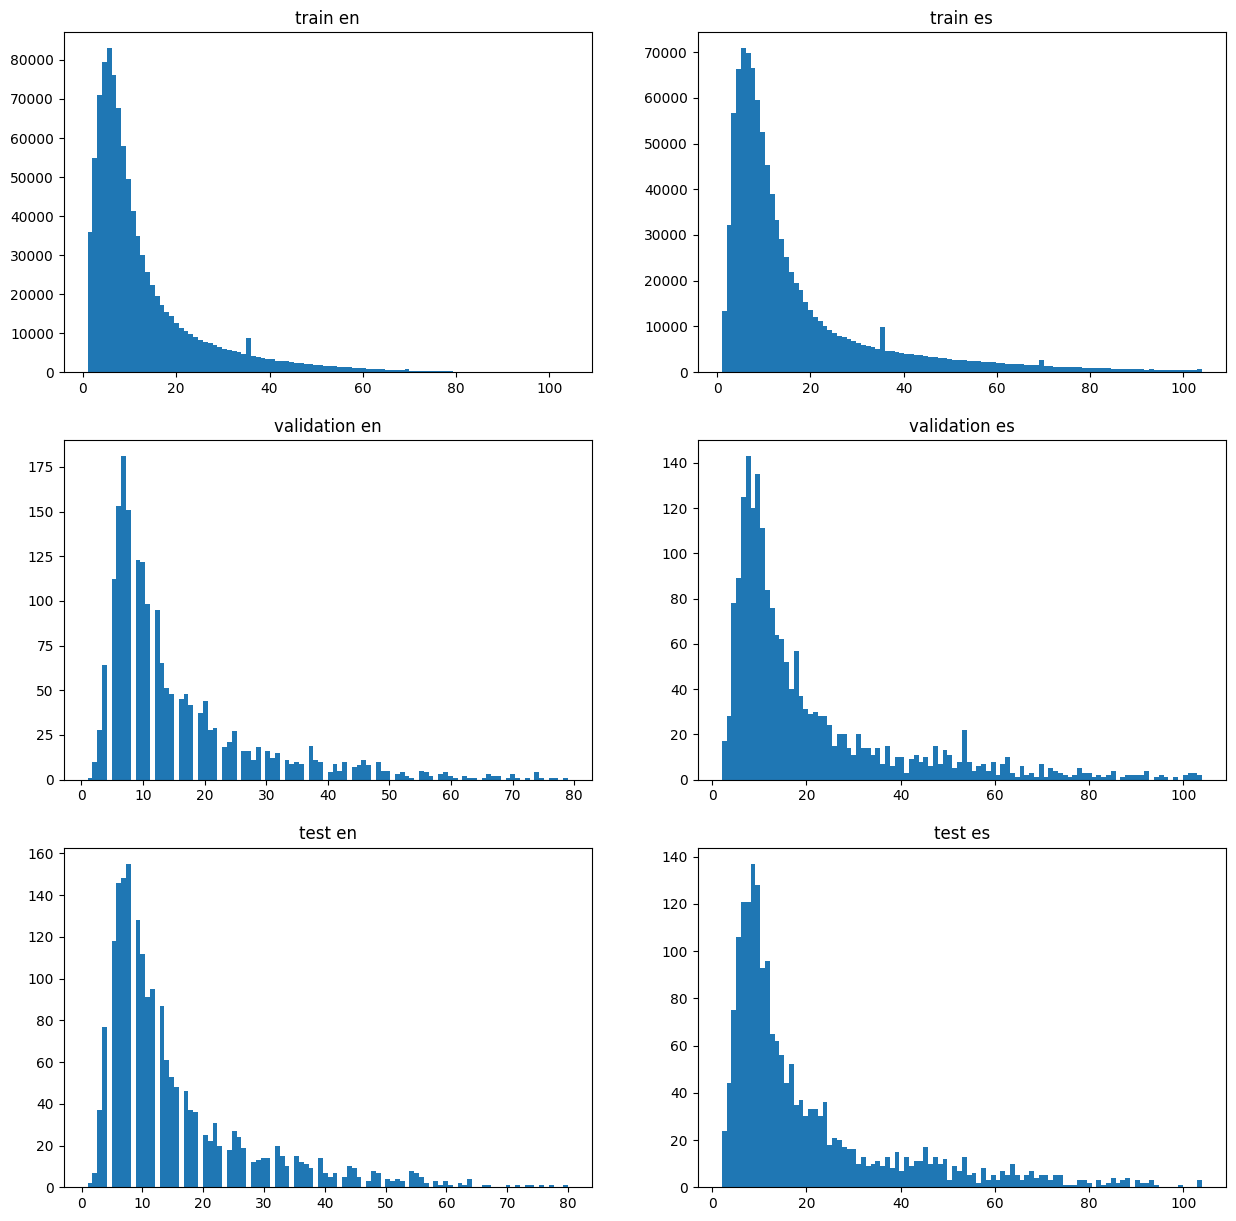

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Guardamos el dataset limpiado para usarlo durante el entrenamiento

In [37]:
import os

path = "data"
if not os.path.exists(path):
    os.makedirs(path)
opus100_croped.save_to_disk(f"{path}/opus100_croped")

Saving the dataset (0/1 shards):   0%|          | 0/1955 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/983138 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1963 [00:00<?, ? examples/s]

Podemos ver que casi todas las secuencias tienen 20 tokens o menos, por lo que vamos a crearnos otro dataset con todas las secuencias que tengan 20 tokens o menos, para que si durante el entrenamiento no tenemos una buena GPU podemos usar este dataset que ocupará menos memoria de la GPU

In [38]:
max_sequence_len = 20
opus100_croped_20 = opus100_croped.filter(lambda example: len(enc.encode(example["translation"]["en"])) <= max_sequence_len and len(enc.encode(example["translation"]["es"])) <= max_sequence_len)

Filter:   0%|          | 0/1955 [00:00<?, ? examples/s]

Filter:   0%|          | 0/983138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1963 [00:00<?, ? examples/s]

In [39]:
print(f"len dataset train: {len(opus100_croped_20['train'])}, se han eliminado {len(opus100['train']) - len(opus100_croped_20['train'])} ejemplos")
print(f"len dataset validation: {len(opus100_croped_20['validation'])}, se han eliminado {len(opus100['validation']) - len(opus100_croped_20['validation'])} ejemplos")
print(f"len dataset test: {len(opus100_croped_20['test'])}, se han eliminado {len(opus100['test']) - len(opus100_croped_20['test'])} ejemplos")
print(f"En total se han eliminado {len(opus100['train']) + len(opus100['validation']) + len(opus100['test']) - len(opus100_croped_20['train']) - len(opus100_croped_20['validation']) - len(opus100_croped_20['test'])} ejemplos")

len dataset train: 741145, se han eliminado 258855 ejemplos
len dataset validation: 1326, se han eliminado 674 ejemplos
len dataset test: 1311, se han eliminado 689 ejemplos
En total se han eliminado 260218 ejemplos


Aquí se han perdido casi un cuarto de las frases, pero aun así seguimos teniendo muchas y vamos a poder usar GPUs menos potentes

Volvemos a ver el histograma

In [40]:
sentence_lengths_train_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped_20["train"]])
sentence_lengths_train_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped_20["train"]])
sentence_lengths_validation_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped_20["validation"]])
sentence_lengths_validation_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped_20["validation"]])
sentence_lengths_test_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped_20["test"]])
sentence_lengths_test_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped_20["test"]])

Text(0.5, 1.0, 'test es')

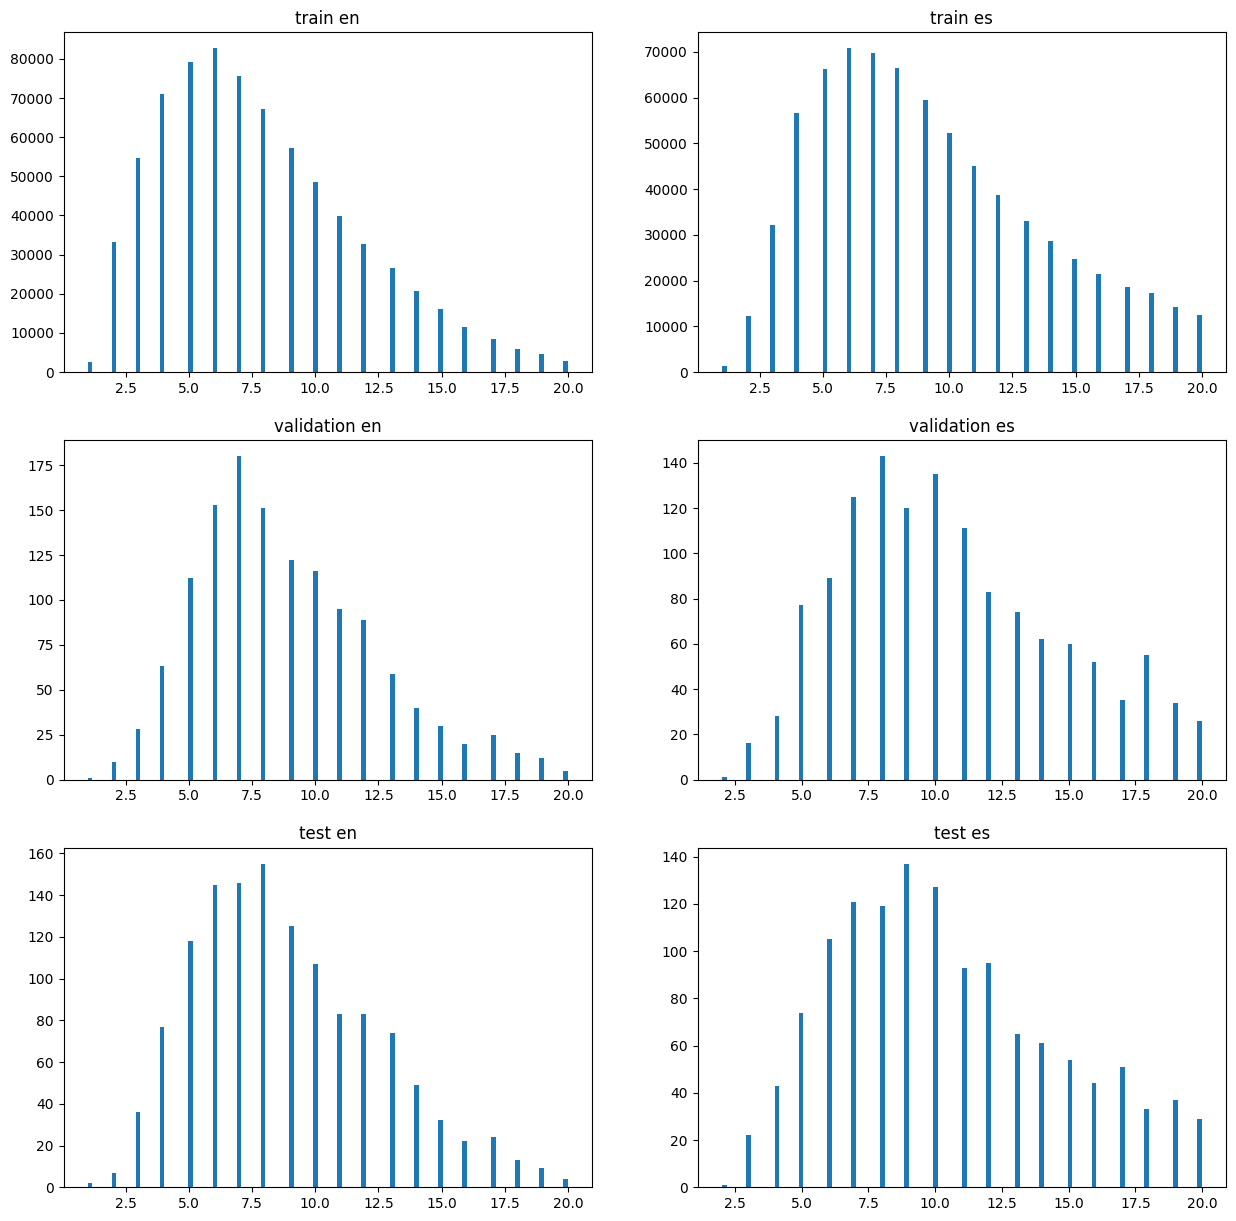

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Guardamos este dataset también por si se quiere usar

In [42]:
path = "data"
if not os.path.exists(path):
    os.makedirs(path)
opus100_croped_20.save_to_disk(f"{path}/opus100_croped_20")

Saving the dataset (0/1 shards):   0%|          | 0/1311 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/741145 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1326 [00:00<?, ? examples/s]

Creamos otro dataset, pero ahora con una longitud máxima de 10 tokens

In [43]:
max_sequence_len = 10
opus100_croped_10 = opus100_croped_20.filter(lambda example: len(enc.encode(example["translation"]["en"])) <= max_sequence_len and len(enc.encode(example["translation"]["es"])) <= max_sequence_len)

Filter:   0%|          | 0/1311 [00:00<?, ? examples/s]

Filter:   0%|          | 0/741145 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1326 [00:00<?, ? examples/s]

In [44]:
print(f"len dataset train: {len(opus100_croped_10['train'])}, se han eliminado {len(opus100['train']) - len(opus100_croped_10['train'])} ejemplos")
print(f"len dataset validation: {len(opus100_croped_10['validation'])}, se han eliminado {len(opus100['validation']) - len(opus100_croped_10['validation'])} ejemplos")
print(f"len dataset test: {len(opus100_croped_10['test'])}, se han eliminado {len(opus100['test']) - len(opus100_croped_10['test'])} ejemplos")
print(f"En total se han eliminado {len(opus100['train']) + len(opus100['validation']) + len(opus100['test']) - len(opus100_croped_10['train']) - len(opus100_croped_10['validation']) - len(opus100_croped_10['test'])} ejemplos")

len dataset train: 463854, se han eliminado 536146 ejemplos
len dataset validation: 681, se han eliminado 1319 ejemplos
len dataset test: 691, se han eliminado 1309 ejemplos
En total se han eliminado 538774 ejemplos


Aquí se han perdido casi la mitad de las frases, pero aun así seguimos teniendo muchas y además vamos a poder usar GPUs menos potentes aún

Volvemos a ver el histograma

In [45]:
sentence_lengths_train_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped_10["train"]])
sentence_lengths_train_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped_10["train"]])
sentence_lengths_validation_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped_10["validation"]])
sentence_lengths_validation_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped_10["validation"]])
sentence_lengths_test_en = np.array([len(enc.encode(example["translation"]["en"])) for example in opus100_croped_10["test"]])
sentence_lengths_test_es = np.array([len(enc.encode(example["translation"]["es"])) for example in opus100_croped_10["test"]])

Text(0.5, 1.0, 'test es')

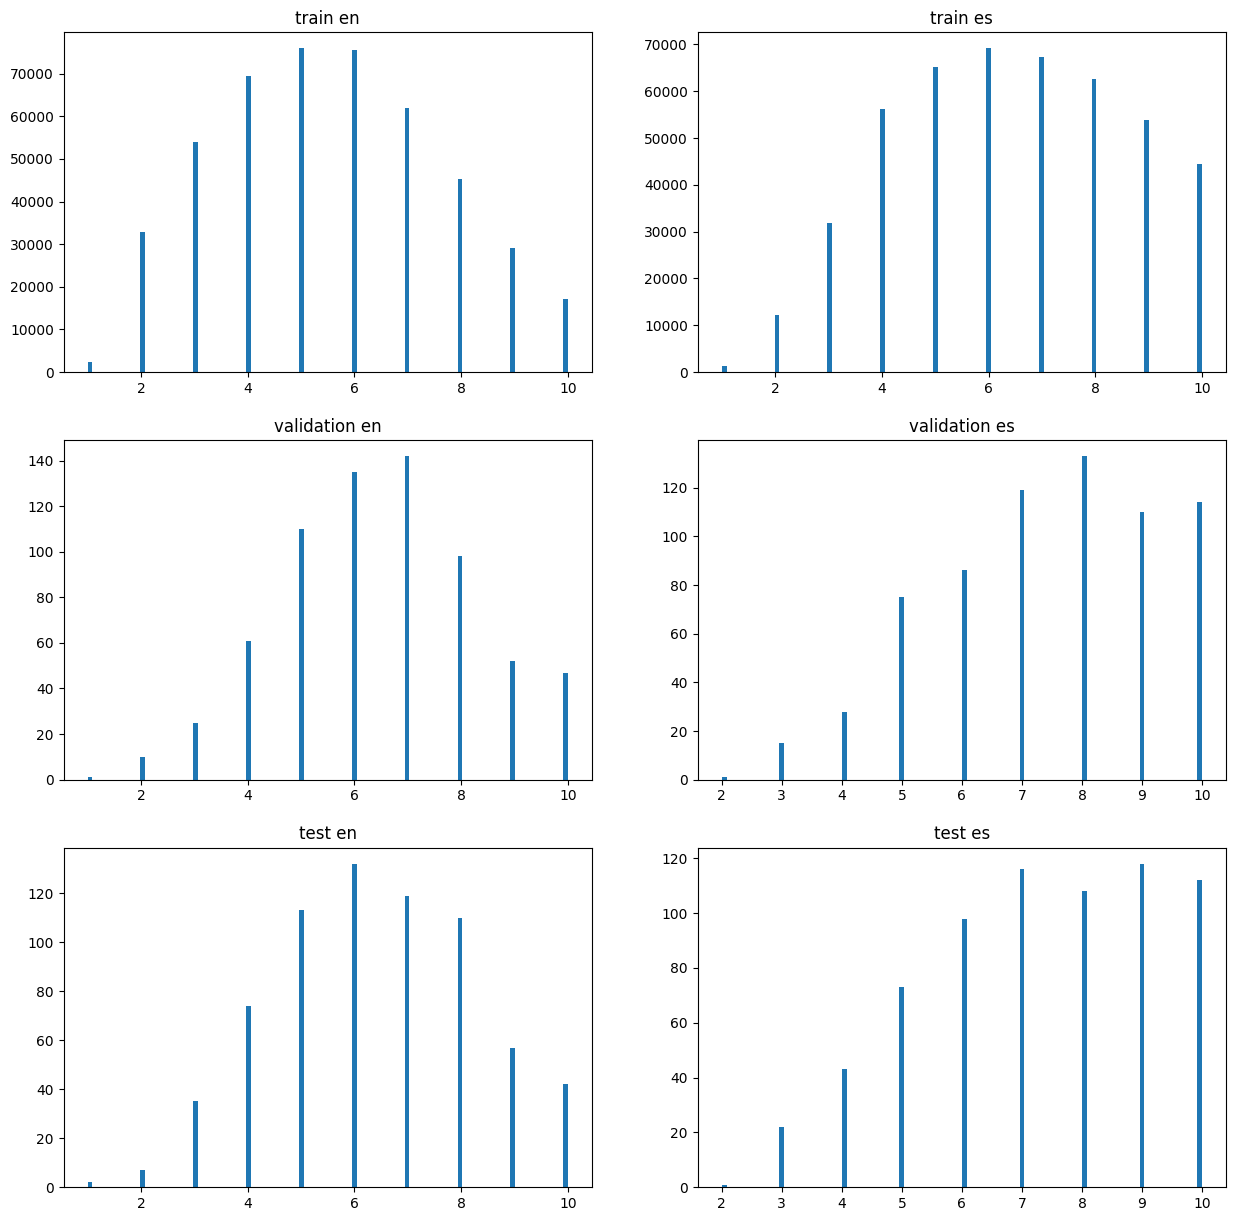

In [46]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Guardamos este dataset también por si se quiere usar

In [47]:
path = "data"
if not os.path.exists(path):
    os.makedirs(path)
opus100_croped_10.save_to_disk(f"{path}/opus100_croped_10")

Saving the dataset (0/1 shards):   0%|          | 0/691 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/463854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/681 [00:00<?, ? examples/s]